# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from scipy.stats import skew
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import xgboost as xgb

# PHẦN 1: QUY TRÌNH KHOA HỌC DỮ LIỆU

## A Thu thập dữ liệu (Data collection)

# <b>Mục tiêu</b>
- Phần thu thập dữ liệu được thực hiện trong file crawl_data.ipynb
- Thu thập dữ liệu về thời tiết tại TP HCM theo từng ngày từ năm 2010 đến năm 2021 trên trang https://www.worldweatheronline.com/ho-chi-minh-city-weather-history/vn.aspx
- Do cần tương tác với trang web trước khi đọc source HTML để tiến hành thu thập dữ liệu do đó phần thu thập dữ liệu sẽ sử dụng thư viện Selenium.
- Các trường dữ liệu sẽ thu thập bao gồm:
    + Weather Type: Loại thời tiết
    + Average Temperature: Nhiệt độ trung bình trong ngày ($^\circ C$)
    + Highest Temperature: Nhiệt độ cao nhất trong ngày ($^\circ C$)
    + Lowest Temperature: Nhiệt độ thấp nhất trong ngày ($^\circ C$)
    + Wind Speed: Tốc độ gió (km/h)
    + Rain: Lượng mưa (mm)
    + Humidity: Độ ẩm (%)
    + Cloud: Độ che phủ của mây (%)
    + Pressure: Áp suất không khí (mb)
- Dữ liệu sau khi thu thập được lưu trữ trong thư mục Data gồm:
    + hcm_weather_info.csv: File CSV chứa dữ liệu gồm các trường dữ liệu như mô tả bên trên.
    + feature_description.csv: File CSV mô tả thông tin của các trường dữ liệu.

## B Khám phá dữ liệu (thường đan xen với tiền xử lý dữ liệu)

### Đọc dữ liệu từ file csv vào dataframe

In [2]:
weather_df = pd.read_csv("Data/hcm_weather_info.csv")
weather_df.head()

,Date,Weather Type,Average Temperature,Highest Temperature,Lowest Temperature,Wind Speed,Rain,Humidity,Cloud,Pressure
0,2010-01-01,Partly cloudy,28.4,34,24,6,0.0,59,20,1010
1,2010-01-02,Cloudy,27.0,32,24,7,0.0,61,48,1010
2,2010-01-03,Partly cloudy,28.1,33,26,7,0.0,65,37,1010
3,2010-01-04,Partly cloudy,28.2,35,25,9,0.1,61,42,1009
4,2010-01-05,Partly cloudy,28.8,35,26,10,0.0,57,35,1009


Thông tin về các cột.

In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 4380 non-null   object 
 1   Weather Type         4380 non-null   object 
 2   Average Temperature  4380 non-null   float64
 3   Highest Temperature  4380 non-null   int64  
 4   Lowest Temperature   4380 non-null   int64  
 5   Wind Speed           4380 non-null   int64  
 6   Rain                 4380 non-null   float64
 7   Humidity             4380 non-null   int64  
 8   Cloud                4380 non-null   int64  
 9   Pressure             4380 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 342.3+ KB


### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

- Mỗi dòng thể hiện các độ đo thời tiết trung bình của 1 ngày.
- Không có vấn đề các dòng có ý nghĩa khác nhau.

### Kiểm tra số dòng, số cột và có giá trị thiếu, trùng lặp hay không?

In [4]:
#shape data
weather_df.shape

(4380, 10)

In [5]:
#check null
weather_df.isnull().sum()

Date                   0
Weather Type           0
Average Temperature    0
Highest Temperature    0
Lowest Temperature     0
Wind Speed             0
Rain                   0
Humidity               0
Cloud                  0
Pressure               0
dtype: int64

Dữ liệu không có cột nào chứa giá trị thiếu

In [6]:
#check duplicated
np.any(weather_df.duplicated())

False

### Mỗi cột có ý nghĩa gì?

 + Date: Ngày/tháng/năm
 + Weather Type: Loại thời tiết
 + Average Temperature: Nhiệt độ trung bình trong ngày ($^\circ C$)
 + Highest Temperature: Nhiệt độ cao nhất trong ngày ($^\circ C$)
 + Lowest Temperature: Nhiệt độ thấp nhất trong ngày ($^\circ C$)
 + Wind Speed: Tốc độ gió (km/h)
 + Rain: Lượng mưa (mm)
 + Humidity: Độ ẩm (%)
 + Cloud: Độ che phủ của mây (%)
 + Pressure: Áp suất không khí (mb)

### Chuyển đổi đúng kiểu dữ liệu của cột

In [7]:
weather_df.dtypes

Date                    object
Weather Type            object
Average Temperature    float64
Highest Temperature      int64
Lowest Temperature       int64
Wind Speed               int64
Rain                   float64
Humidity                 int64
Cloud                    int64
Pressure                 int64
dtype: object

Chuyển cột "Date" từ object sang datetime64[ns]

In [8]:
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

### Với cột có kiểu dữ liệu phân loại ( "Weather Type" )

In [9]:
cat_attributes = ["Weather Type"]

In [10]:
def num_diff_vals(s):
    return s.nunique()
def diff_vals(s):
    return s.unique()
weather_df[cat_attributes].agg([num_diff_vals, diff_vals])

,Weather Type
num_diff_vals,20
diff_vals,"[Partly cloudy, Cloudy, Sunny, Patchy light dr..."


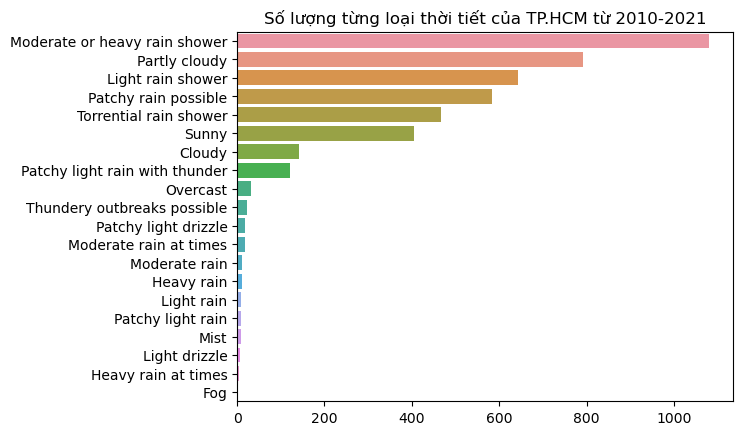

In [11]:
count_weather = weather_df['Weather Type'].value_counts()
sns.barplot(y=count_weather.index, x = count_weather.values, orient='h').set(title= "Số lượng từng loại thời tiết của TP.HCM từ 2010-2021");

### Với cột có kiểu dữ liệu số

In [12]:
num_attributes = ['Average Temperature', 'Highest Temperature', 'Lowest Temperature', 
              'Wind Speed', 'Rain', 'Humidity', 'Cloud', 'Pressure']

In [13]:
weather_df.describe()

,Average Temperature,Highest Temperature,Lowest Temperature,Wind Speed,Rain,Humidity,Cloud,Pressure
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000
mean,28.376712,33.035616,25.200228,9.413014,7.477968,73.594521,37.042466,1009.256849
std,1.655659,2.474554,1.647616,3.431909,10.980748,10.010817,18.737816,2.076964
min,21.400000,22.000000,16.000000,3.000000,0.000000,45.000000,0.000000,1003.000000
25%,27.400000,32.000000,24.000000,7.000000,0.100000,66.000000,23.000000,1008.000000
50%,28.200000,33.000000,25.000000,9.000000,3.300000,75.000000,34.000000,1009.000000
75%,29.500000,35.000000,26.000000,12.000000,11.100000,82.000000,50.000000,1011.000000
max,33.800000,41.000000,30.000000,26.000000,253.300000,96.000000,99.000000,1016.000000


**Ta thấy giá trị min và max của các attribute có sự chênh lệch**

### Phân bố của các cột dữ liệu số

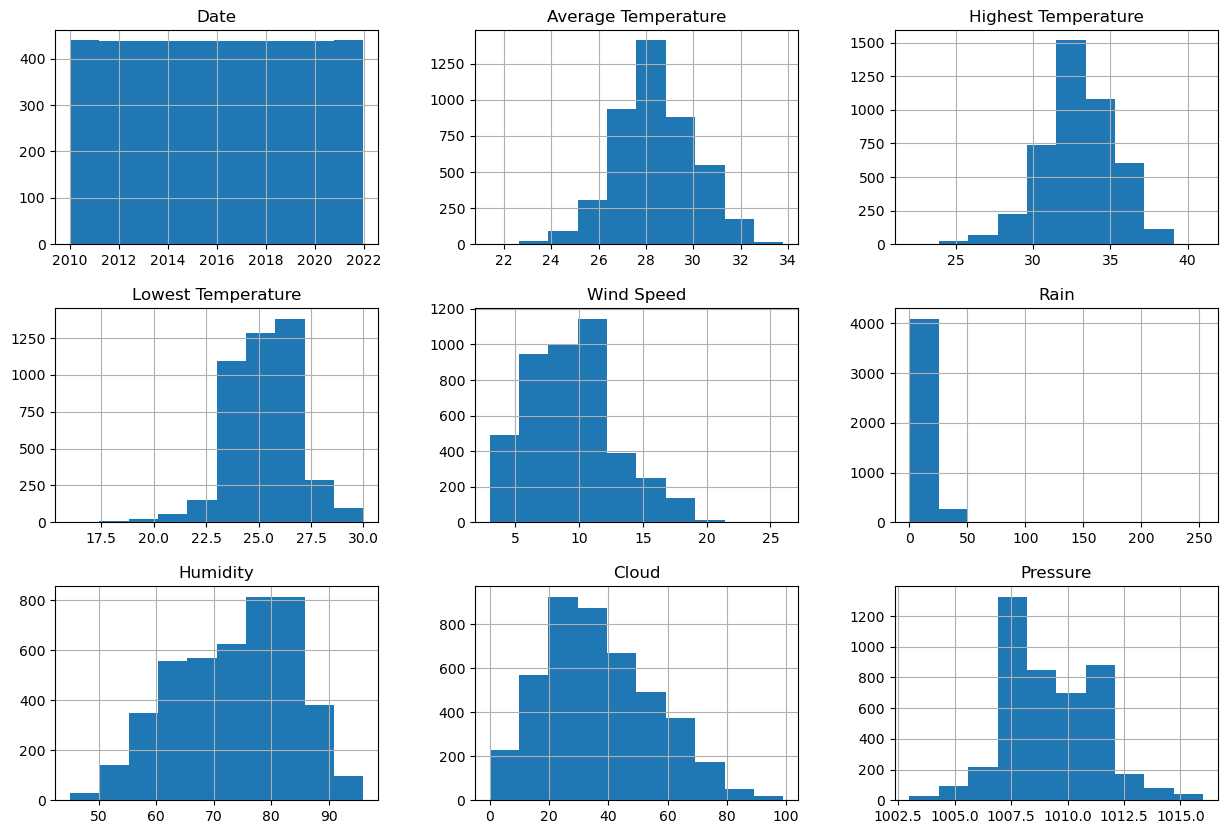

In [14]:
# Histogram of Numeric Columns
fig, ax  = plt.subplots(3,3,figsize = (15,10))
weather_df.hist(ax=ax);

## C Đặt các câu hỏi có ý nghĩa cần trả lời và trả lời câu hỏi

### Câu 1: Nhiệt độ cao nhất trong ngày, Nhiệt độ thấp nhất trong ngày, Tốc độ gió, Lượng mưa, Độ ẩm, Độ che phủ của mây, Áp suất không khí trung bình theo từng năm thay đổi như thế nào

In [15]:
df_year = weather_df.copy()
df_year['Year'] = df_year['Date'].dt.year
x = df_year['Year'].unique()

#Highest_Temperature = df_year[['Year','Highest Temperature']].groupby('Year').mean()
#Lowest_Temperature = df_year[['Year','Lowest Temperature']].groupby('Year').mean()

y1 = df_year[['Year','Highest Temperature']].groupby('Year').mean().values.round(1).flat[:]
y2 = df_year[['Year','Lowest Temperature']].groupby('Year').mean().values.round(1).flat[:]
y3 = df_year[['Year','Wind Speed']].groupby('Year').mean().values.round(1).flat[:]
y4 = df_year[['Year','Rain']].groupby('Year').mean().values.round(1).flat[:]
y5 = df_year[['Year','Humidity']].groupby('Year').mean().values.round(1).flat[:]
y6 = df_year[['Year','Cloud']].groupby('Year').mean().values.round(1).flat[:]
y7 = df_year[['Year','Pressure']].groupby('Year').mean().values.round(1).flat[:]

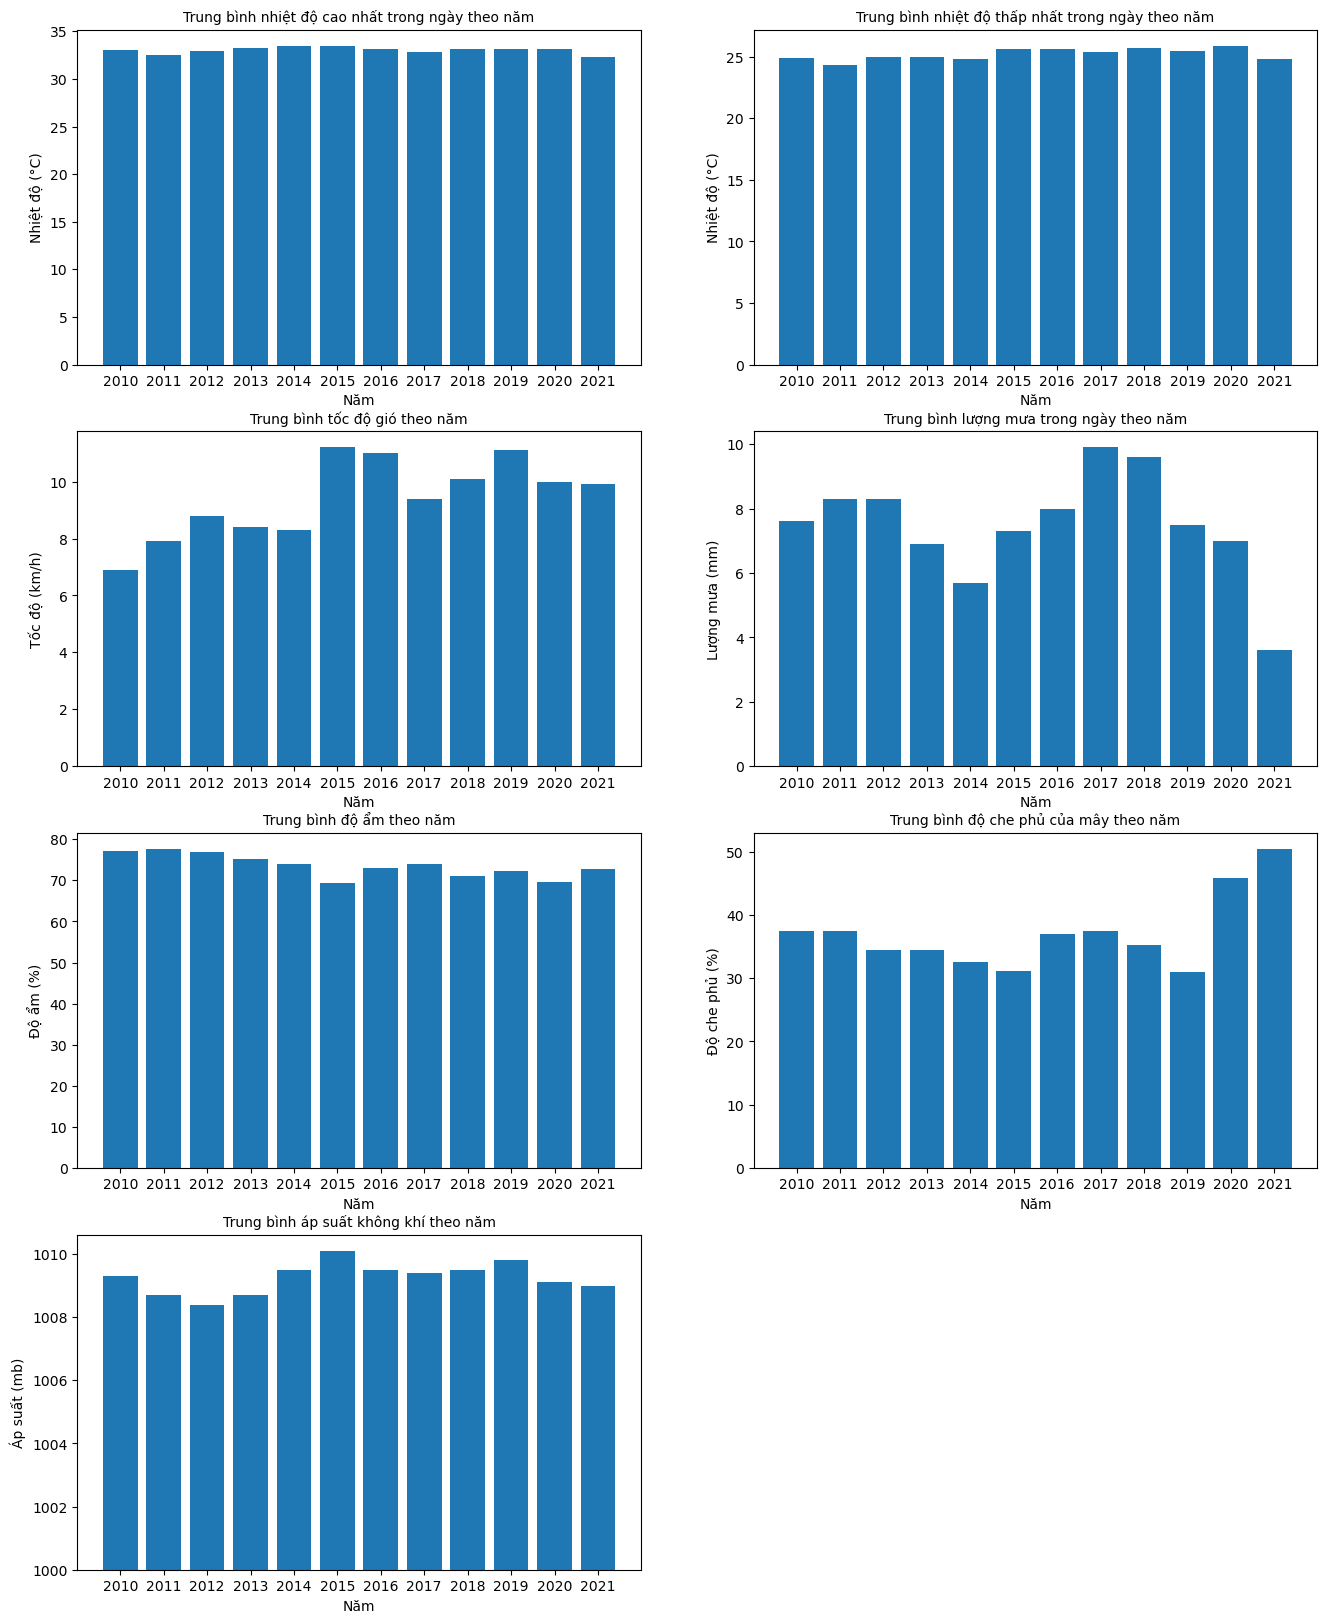

In [16]:
plt.figure(figsize=(16,20))
plt.subplot(4, 2, 1)
font = {'size':10}

plt.bar(x,y1)
plt.xticks(x)
plt.title("Trung bình nhiệt độ cao nhất trong ngày theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Nhiệt độ (°C)",fontdict = font)

#plt.plot(x,y1)

plt.subplot(4, 2, 2)
plt.bar(x,y2)
plt.xticks(x)
plt.title("Trung bình nhiệt độ thấp nhất trong ngày theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Nhiệt độ (°C)",fontdict = font)

plt.subplot(4, 2, 3)
plt.bar(x,y3)
plt.xticks(x)
plt.title("Trung bình tốc độ gió theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Tốc độ (km/h)",fontdict = font)

plt.subplot(4, 2, 4)
plt.bar(x,y4)
plt.xticks(x)
plt.title("Trung bình lượng mưa trong ngày theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Lượng mưa (mm)",fontdict = font)

plt.subplot(4, 2, 5)
plt.bar(x,y5)
plt.xticks(x)
plt.title("Trung bình độ ẩm theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Độ ẩm (%)",fontdict = font)

plt.subplot(4, 2, 6)
plt.bar(x,y6)
plt.xticks(x)
plt.title("Trung bình độ che phủ của mây theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Độ che phủ (%)",fontdict = font)

plt.subplot(4, 2, 7)
plt.bar(x,y7-1000,bottom=1000)
plt.xticks(x)
plt.title("Trung bình áp suất không khí theo năm",fontdict = font)
plt.xlabel("Năm",fontdict = font)
plt.ylabel("Áp suất (mb)",fontdict = font)

#plt.xticks(size=8)
#plt.yticks(size=8)
#plt.legend(loc='center right',fontsize='xx-small')

plt.show()

- Ta có thể thấy trung bình nhiệt độ cao nhất thấp nhất trong ngày, độ ẩm, áp suất không có biến động nhiều qua các năm.
- Tốc độ gió có xu hướng tăng dần và cao nhất vào năm 2015.
- Lượng mưa biến động thất thường, năm thấp nhất là 2021 lượng mưa không bằng một nữa của 2015.
- Độ che phủ của mây có sự tăng đột ngột vào năm 2020 và 2021.</br>
Những phân tích trên nhầm để có cái nhìn tổng quát về sự thay đổi của những chỉ số thời tiết qua các năm.

### Câu 2: Lượng mưa của từng tháng trong các năm biến đổi như thế nào

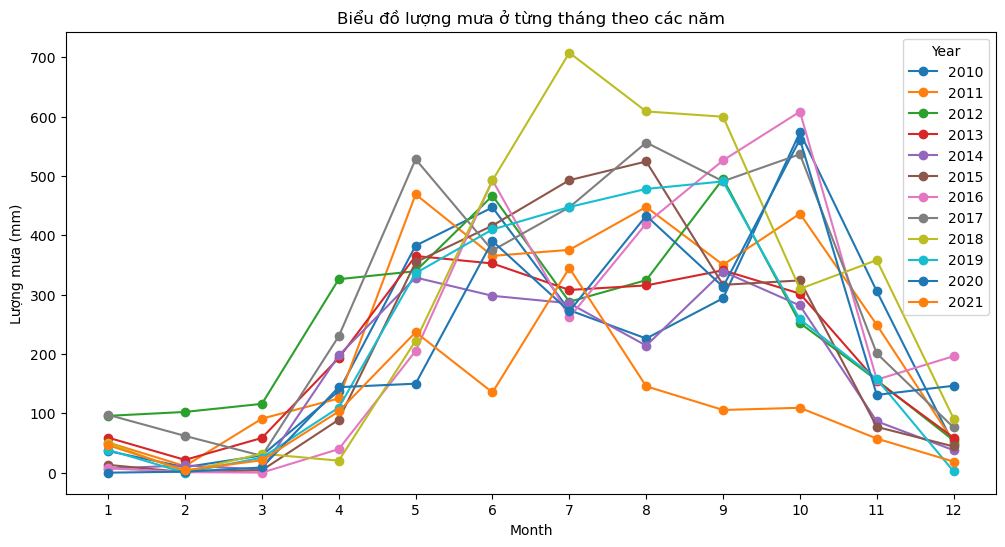

In [17]:
df_rain = df_year.copy()
df_rain['Month'] = df_rain['Date'].dt.month
x = df_rain['Month'].unique()
df_rain[['Year', 'Month', 'Rain']].groupby(['Month','Year']).sum().squeeze().unstack()\
                .plot(marker = 'o',figsize=(12, 6), legend=True, ylabel='Lượng mưa (mm)',\
                      title='Biểu đồ lượng mưa ở từng tháng theo các năm')
plt.xticks(x);

- **Để dễ quan sát hơn, ta sẽ quan sát trên 2 biểu đồ 2010-2015 và 2016-2021**

In [18]:
rain_2010_2015 = np.array_split(df_rain[['Year', 'Month', 'Rain']],2)[0]
rain_2016_2021 = np.array_split(df_rain[['Year', 'Month', 'Rain']],2)[1]

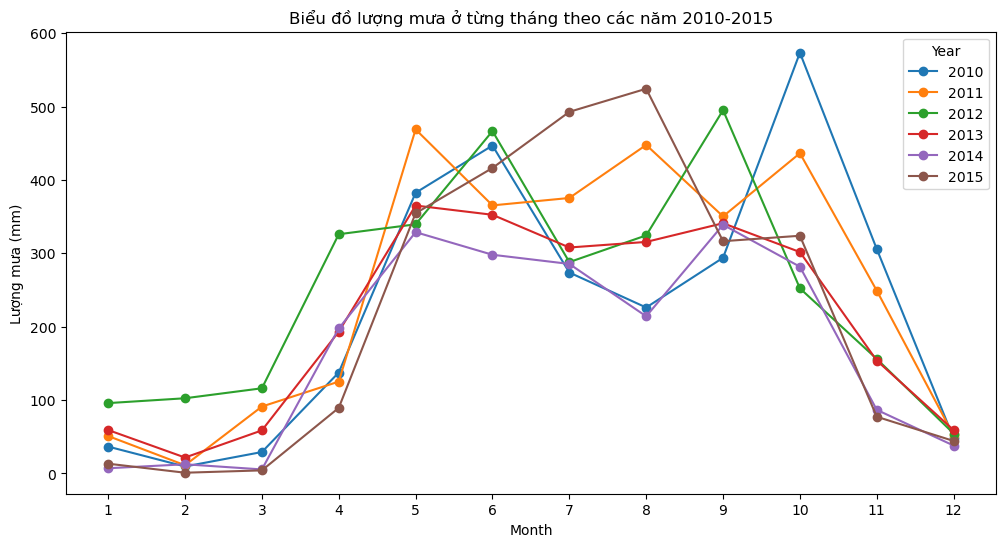

In [19]:
rain_2010_2015.groupby(['Month','Year']).sum().squeeze().unstack()\
                .plot(marker = 'o',figsize=(12, 6), legend=True,ylabel='Lượng mưa (mm)',\
                      title='Biểu đồ lượng mưa ở từng tháng theo các năm 2010-2015')
plt.xticks(x);

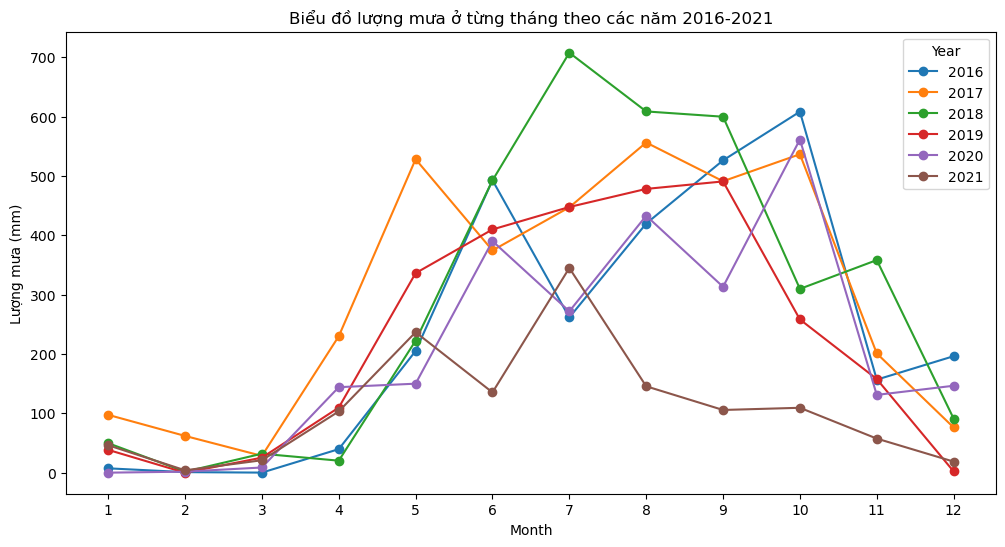

In [20]:
rain_2016_2021.groupby(['Month','Year']).sum().squeeze().unstack()\
                .plot(marker = 'o',figsize=(12, 6), legend=True,ylabel='Lượng mưa (mm)',\
                      title='Biểu đồ lượng mưa ở từng tháng theo các năm 2016-2021')
plt.xticks(x);

* Nhận xét:
    - Tuy có sự khác biệt phần nào giữa các năm. Nhưng nhìn chung lượng mưa duy trì ở mức cao và đạt định trong các tháng từ 5-10.
    - Năm khác biệt nhất là 2021 khi lượng mưa chỉ ở mức cao vào tháng 5 và 7 và cũng tương đối thấp nếu so với cùng kỳ của các năm khác
* Lợi ích đạt được từ câu hỏi:
    - Ta có thể thấy rõ thời gian của mùa mưa và mùa khô ở Tp HCM
* Nguồn cảm hứng:
    - Có thể biết được vào những tháng nào thì ta nên nên chuẩn bị tâm lý xe sẽ chết máy khi lội nước trên những con đường ở tp HCM chẳng hạn :v

### Câu 3: Loại thời tiết nào thường xuyên xuất hiện nhất ở tp HCM

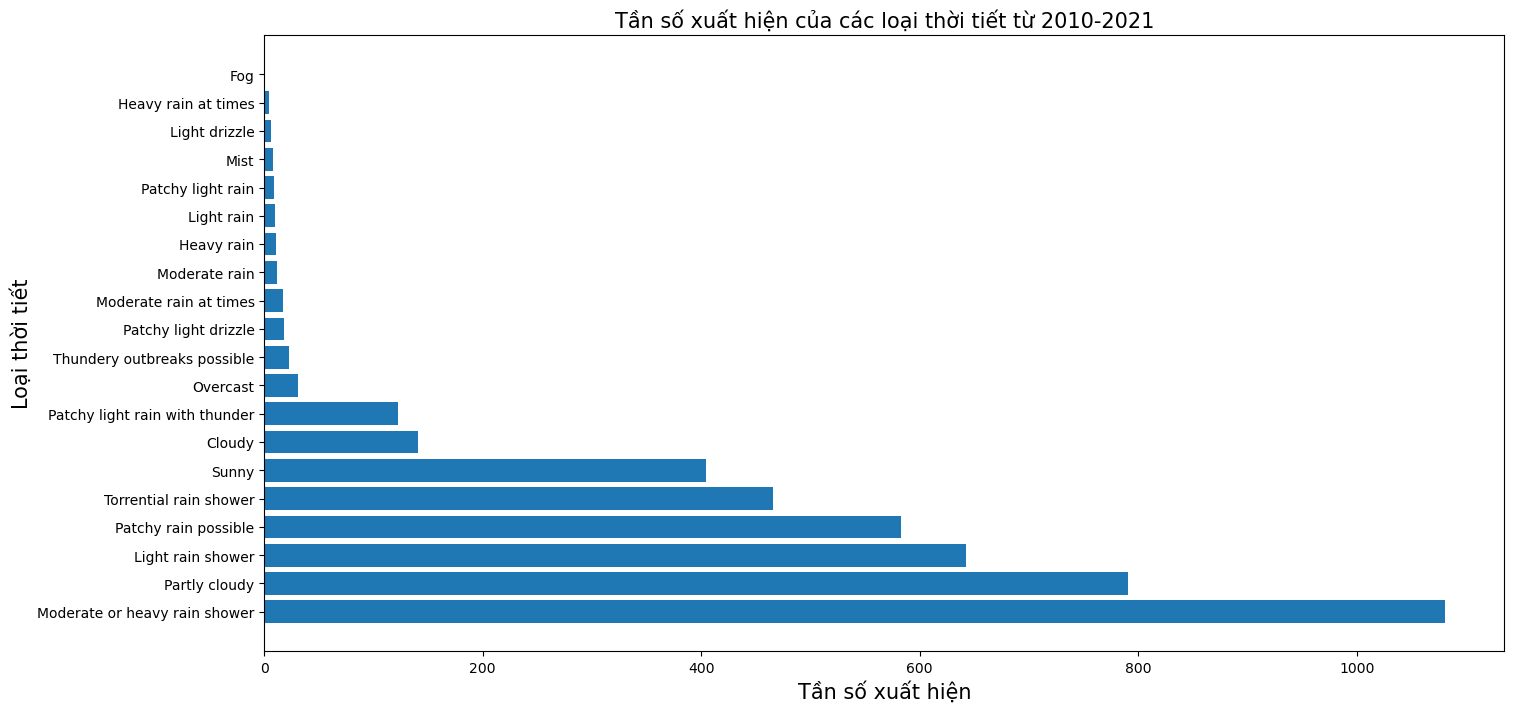

In [21]:
df = weather_df.copy()
x = df['Weather Type'].value_counts().index
y = df['Weather Type'].value_counts().values

font = {'size': 15}
plt.figure(figsize=(16,8))
plt.barh(x,y)
plt.xlabel('Tần số xuất hiện',fontdict=font)
plt.ylabel('Loại thời tiết',fontdict=font)
plt.title('Tần số xuất hiện của các loại thời tiết từ 2010-2021',fontdict=font)
plt.show()

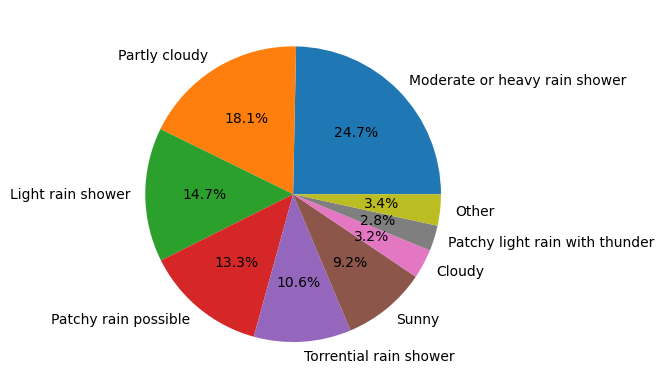

In [22]:
y_pie = y[:8]
y_pie = np.append(y_pie,y[8:].sum())
x_pie = np.append(x[:8],'Other')
plt.pie(y_pie,labels=x_pie,autopct='%1.1f%%');

* Nhận xét:
    - Có 6 kiểu thời tiết phổ biến là: Moderate or heavy rain shower, Partly cloudy, Light rain shower,Patchy rain possible, Torrential rain shower, Sunny chiếm hơn 90%
    - Theo quan sát kiểu thời tiết thì dường như hầu hết không có mưa cũng sẽ có mây
* Lợi ích đạt được từ câu hỏi:
    - Hiểu được kiểu thời tiết ở Tp HCM
* Nguồn cảm hứng:
    - Người ta thường nói Sài Gòn hay có những cơn mưa bất chợt

### Câu 4: So sánh sự chênh lệch nhiệt độ cao nhất và thấp nhất

In [23]:
df_Temperature = df.copy()
df_Temperature['Year'] = df['Date'].dt.year
df_Temperature['Month'] = df['Date'].dt.month
df_Temperature = df_Temperature[['Lowest Temperature','Highest Temperature','Month','Year']]
df_Temperature['Difference'] = df_Temperature['Highest Temperature'] - df_Temperature['Lowest Temperature']

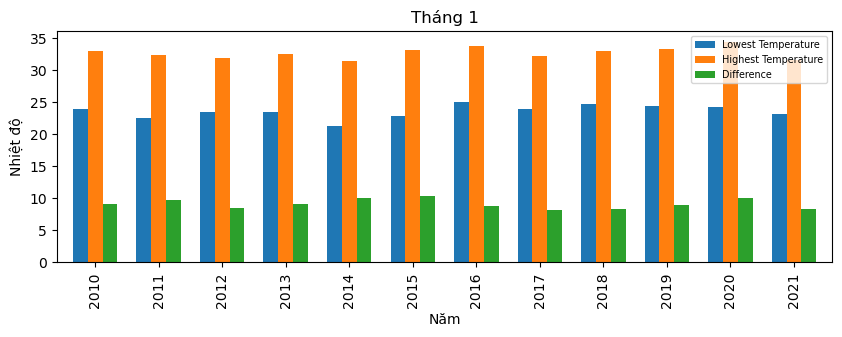

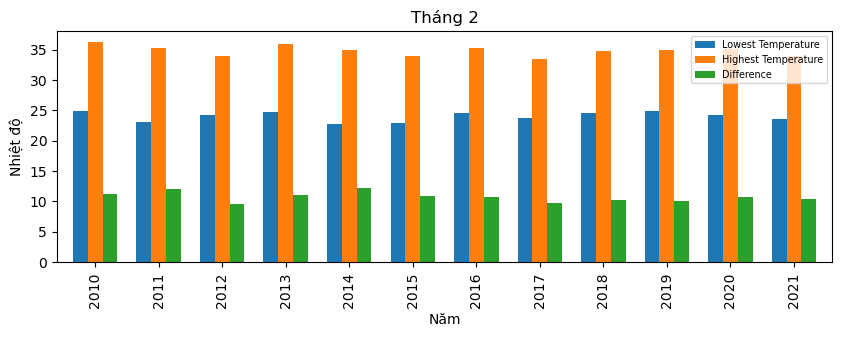

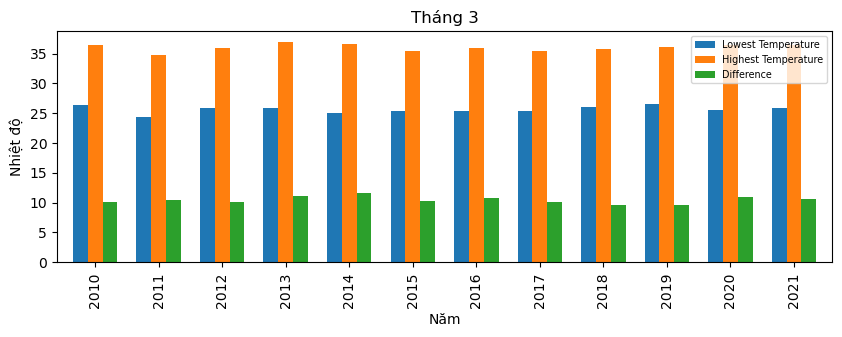

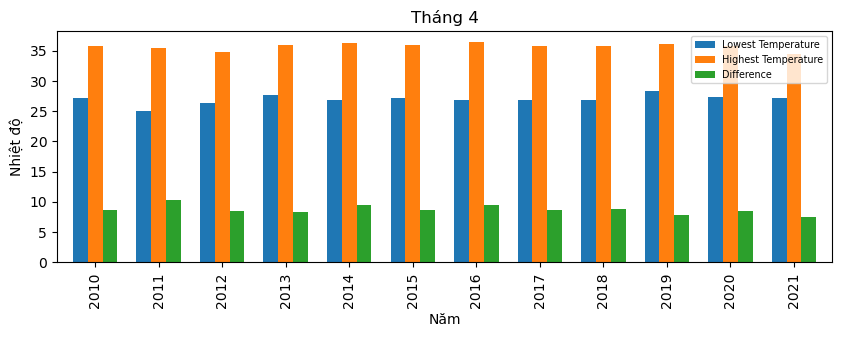

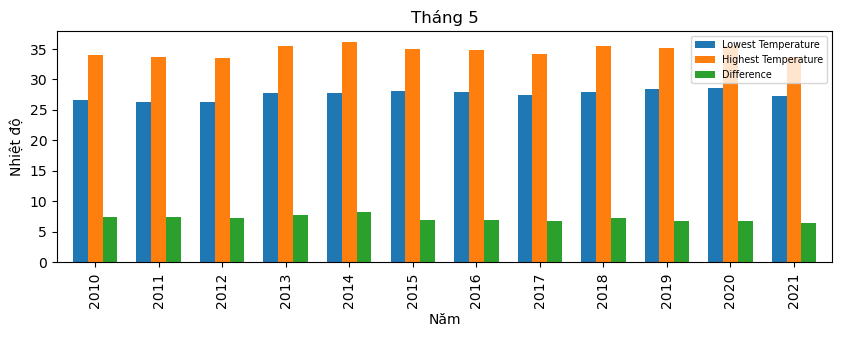

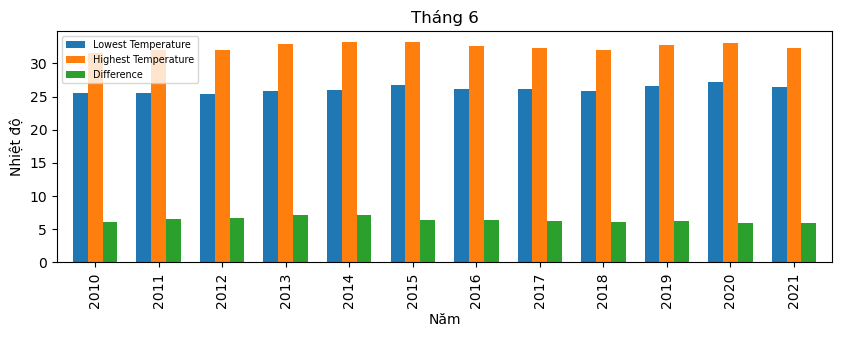

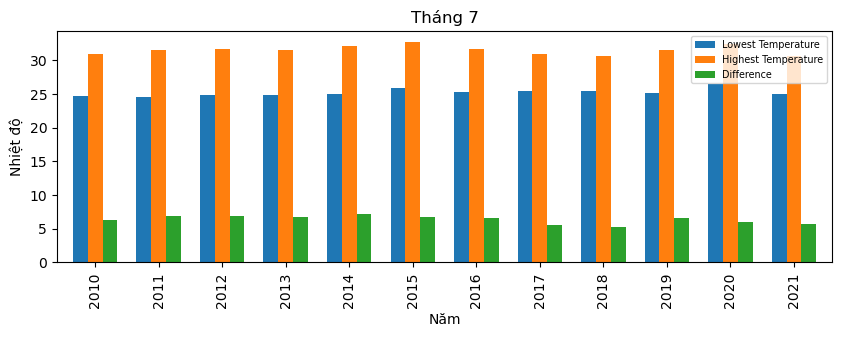

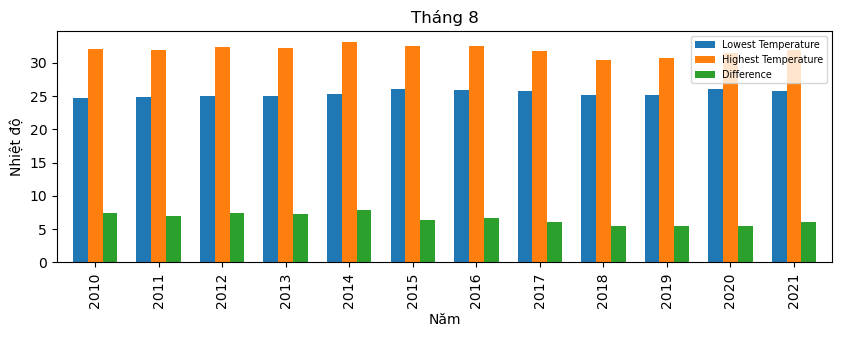

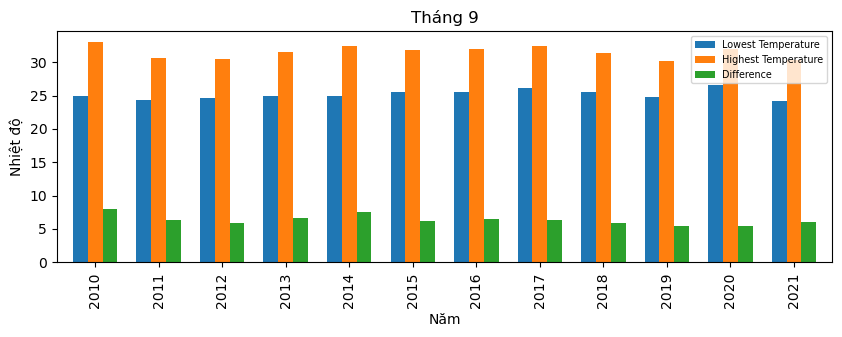

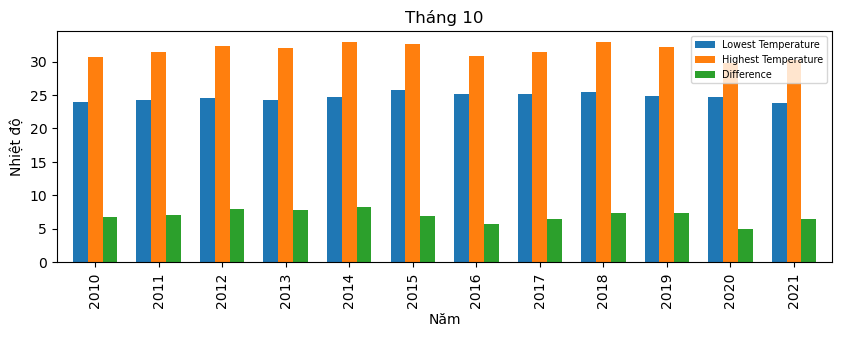

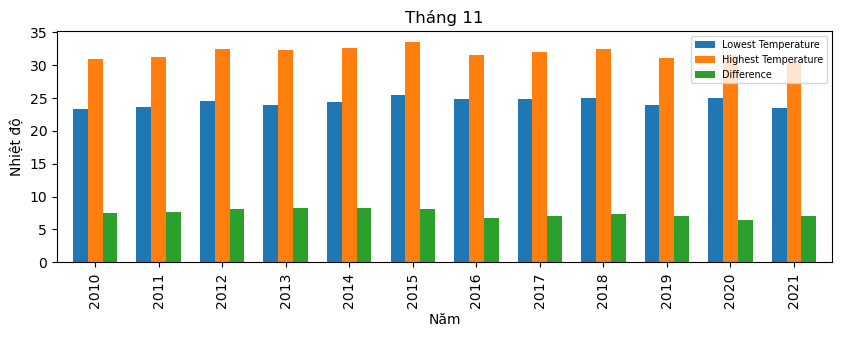

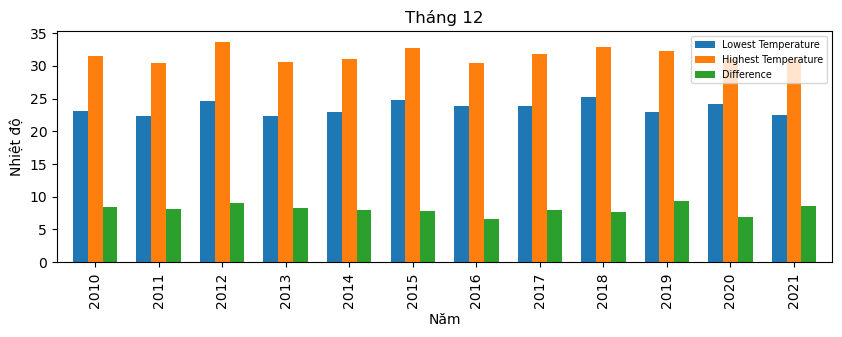

In [24]:
for i in range(1,13,1):
    df_Temperature.groupby(['Month','Year']).mean().round(1).loc[i].plot(kind='bar',width=0.7,figsize=(10,3));
    plt.title(f'Tháng {i}')
    plt.xlabel('Năm')
    plt.ylabel('Nhiệt độ')
    plt.legend(fontsize='x-small')
    plt.show()

- Ta có thể thấy sự biến động về nhiệt độ cao nhất và thấp nhất trong ngày giữa các năm lớn hơn vào ở các tháng cuối năm như 10,11,1.

### Câu 5: Mối liên hệ giữa tốc độ gió và độ ẩm đến loại thời tiết

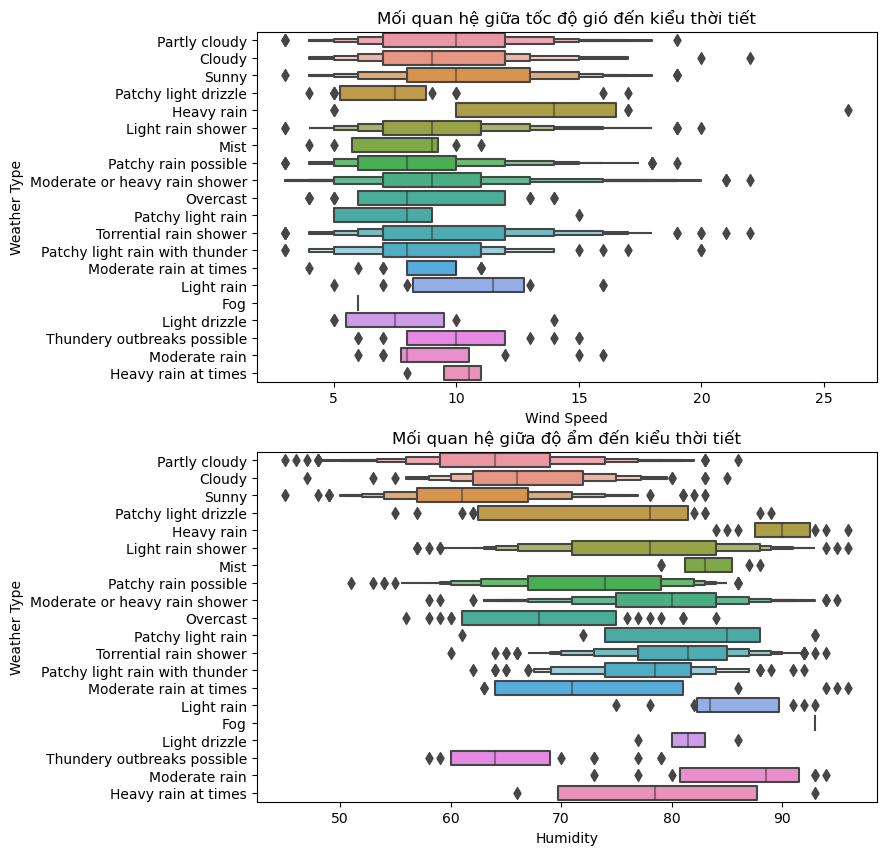

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(8,10))

sns.boxenplot(ax=axes[0],data=df,x='Wind Speed',y='Weather Type')
axes[0].set_title('Mối quan hệ giữa tốc độ gió đến kiểu thời tiết')
sns.boxenplot(ax=axes[1],data=df,x='Humidity',y='Weather Type')
axes[1].set_title('Mối quan hệ giữa độ ẩm đến kiểu thời tiết');

### Câu 6: Số lần xuất hiện trung bình của các loại thời tiết ở các tháng qua các năm?**

Ở đây em chỉ định các loại thời tiết là 'Partly cloudy','Moderate or heavy rain shower', 'Sunny', 'Torrential rain shower','Patchy rain possible'.

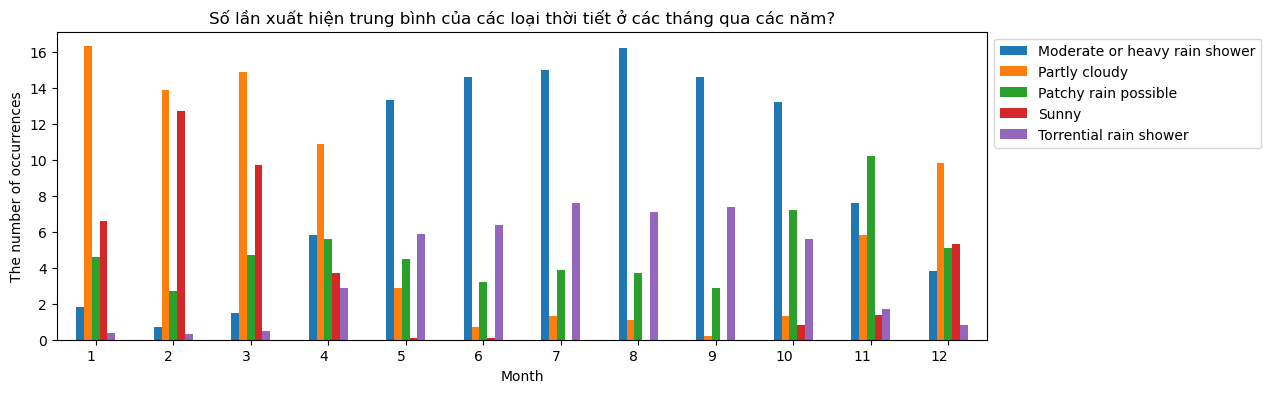

In [26]:
specific_type = ['Partly cloudy','Moderate or heavy rain shower', 'Sunny', 'Torrential rain shower','Patchy rain possible']

df_rain_type = df_rain.copy()
df_rain_type = df_rain_type[df_rain_type['Weather Type'].isin(specific_type)]
df_rain_type.groupby('Month')['Weather Type'].value_counts().divide(other = 10).unstack().plot.bar(figsize=(12,4),  ylabel = 'The number of occurrences')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0, ha='right')
plt.title('Số lần xuất hiện trung bình của các loại thời tiết ở các tháng qua các năm?');

* Lợi ích từ câu hỏi: Biết được các tháng mà các loại thời tiết này thường xuất hiện mà ta có thể chủ động trong các tình huống như: 
  * Lựa chọn việc di chuyển bằng các phương tiện công cộng
  * Có sự lưu ý về những tháng có nhiều mưa.
  * Chọn được những tháng có thời tiết đẹp để đi dạo phố.
* Như biểu đồ ta có thể thấy là những tháng có nhiều ngày đẹp trời thường rơi vào tháng 1 đến tháng 3. Đó là khoảng thời gian Tết của Việt Nam, rất thích hợp cho việc đi chơi!

### Câu 7: Sự tương quan giữa Nhiệt độ cao nhất và Độ ẩm trung bình ở các tháng qua các năm**

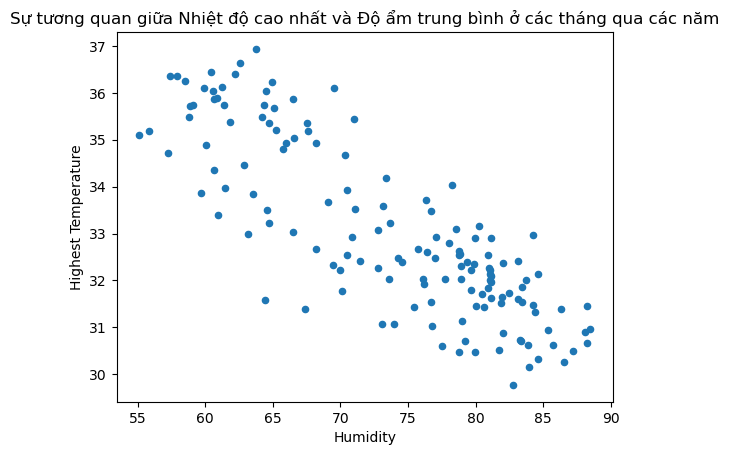

In [27]:
df_month_year = df.groupby([df['Date'].dt.year, df['Date'].dt.month]).mean(numeric_only = True)
df_month_year.plot('Humidity', 'Highest Temperature', kind = 'scatter') 
plt.title('Sự tương quan giữa Nhiệt độ cao nhất và Độ ẩm trung bình ở các tháng qua các năm');

* Từ biểu đồ ta có thể thấy nhiệt độ và độ ẩm luôn là yếu tố song hành và tác động qua lại lẫn nhau. Khi nhiệt độ tăng đồng nghĩa tốc độ bay hơi của nước ngày càng nhanh, độ ẩm trong không khí sẽ giảm và ngược lại. Đây là hiện tượng quen thuộc vào những ngày nóng nực mùa hè.
* Nhiệt độ và độ ẩm là hai thông số ảnh hưởng trực tiếp đến sức khỏe con người. Vào mùa đông, bạn sẽ rất dễ gặp phải những loại bệnh về đường hô hấp và nứt da, chảy máu tại các vùng da khô như khuỷu tay, gót chân. Và những ngày mùa hè nóng nực, chúng ta sẽ rất dễ bị choáng váng do mất nước và say nắng do nhiệt độ cao.
* Để đảm bảo sức khỏe cho bản thân và gia đình, bạn cần trang bị những kiến thức về nhiệt độ và độ ẩm là điều cần thiết. VD: cân bằng độ ẩm trong không gian sống của mình bằng cách sử dụng máy hút ẩm, điều hòa, dùng giẻ khô để lau nhà,...

# PHẦN 2: MÔ HÌNH HÓA DỮ LIỆU

## A Khám phá dữ liệu

Vẽ Scatter plot của từng thuộc tính số này với thuộc tính số khác và Histogram của từng thuộc tính số

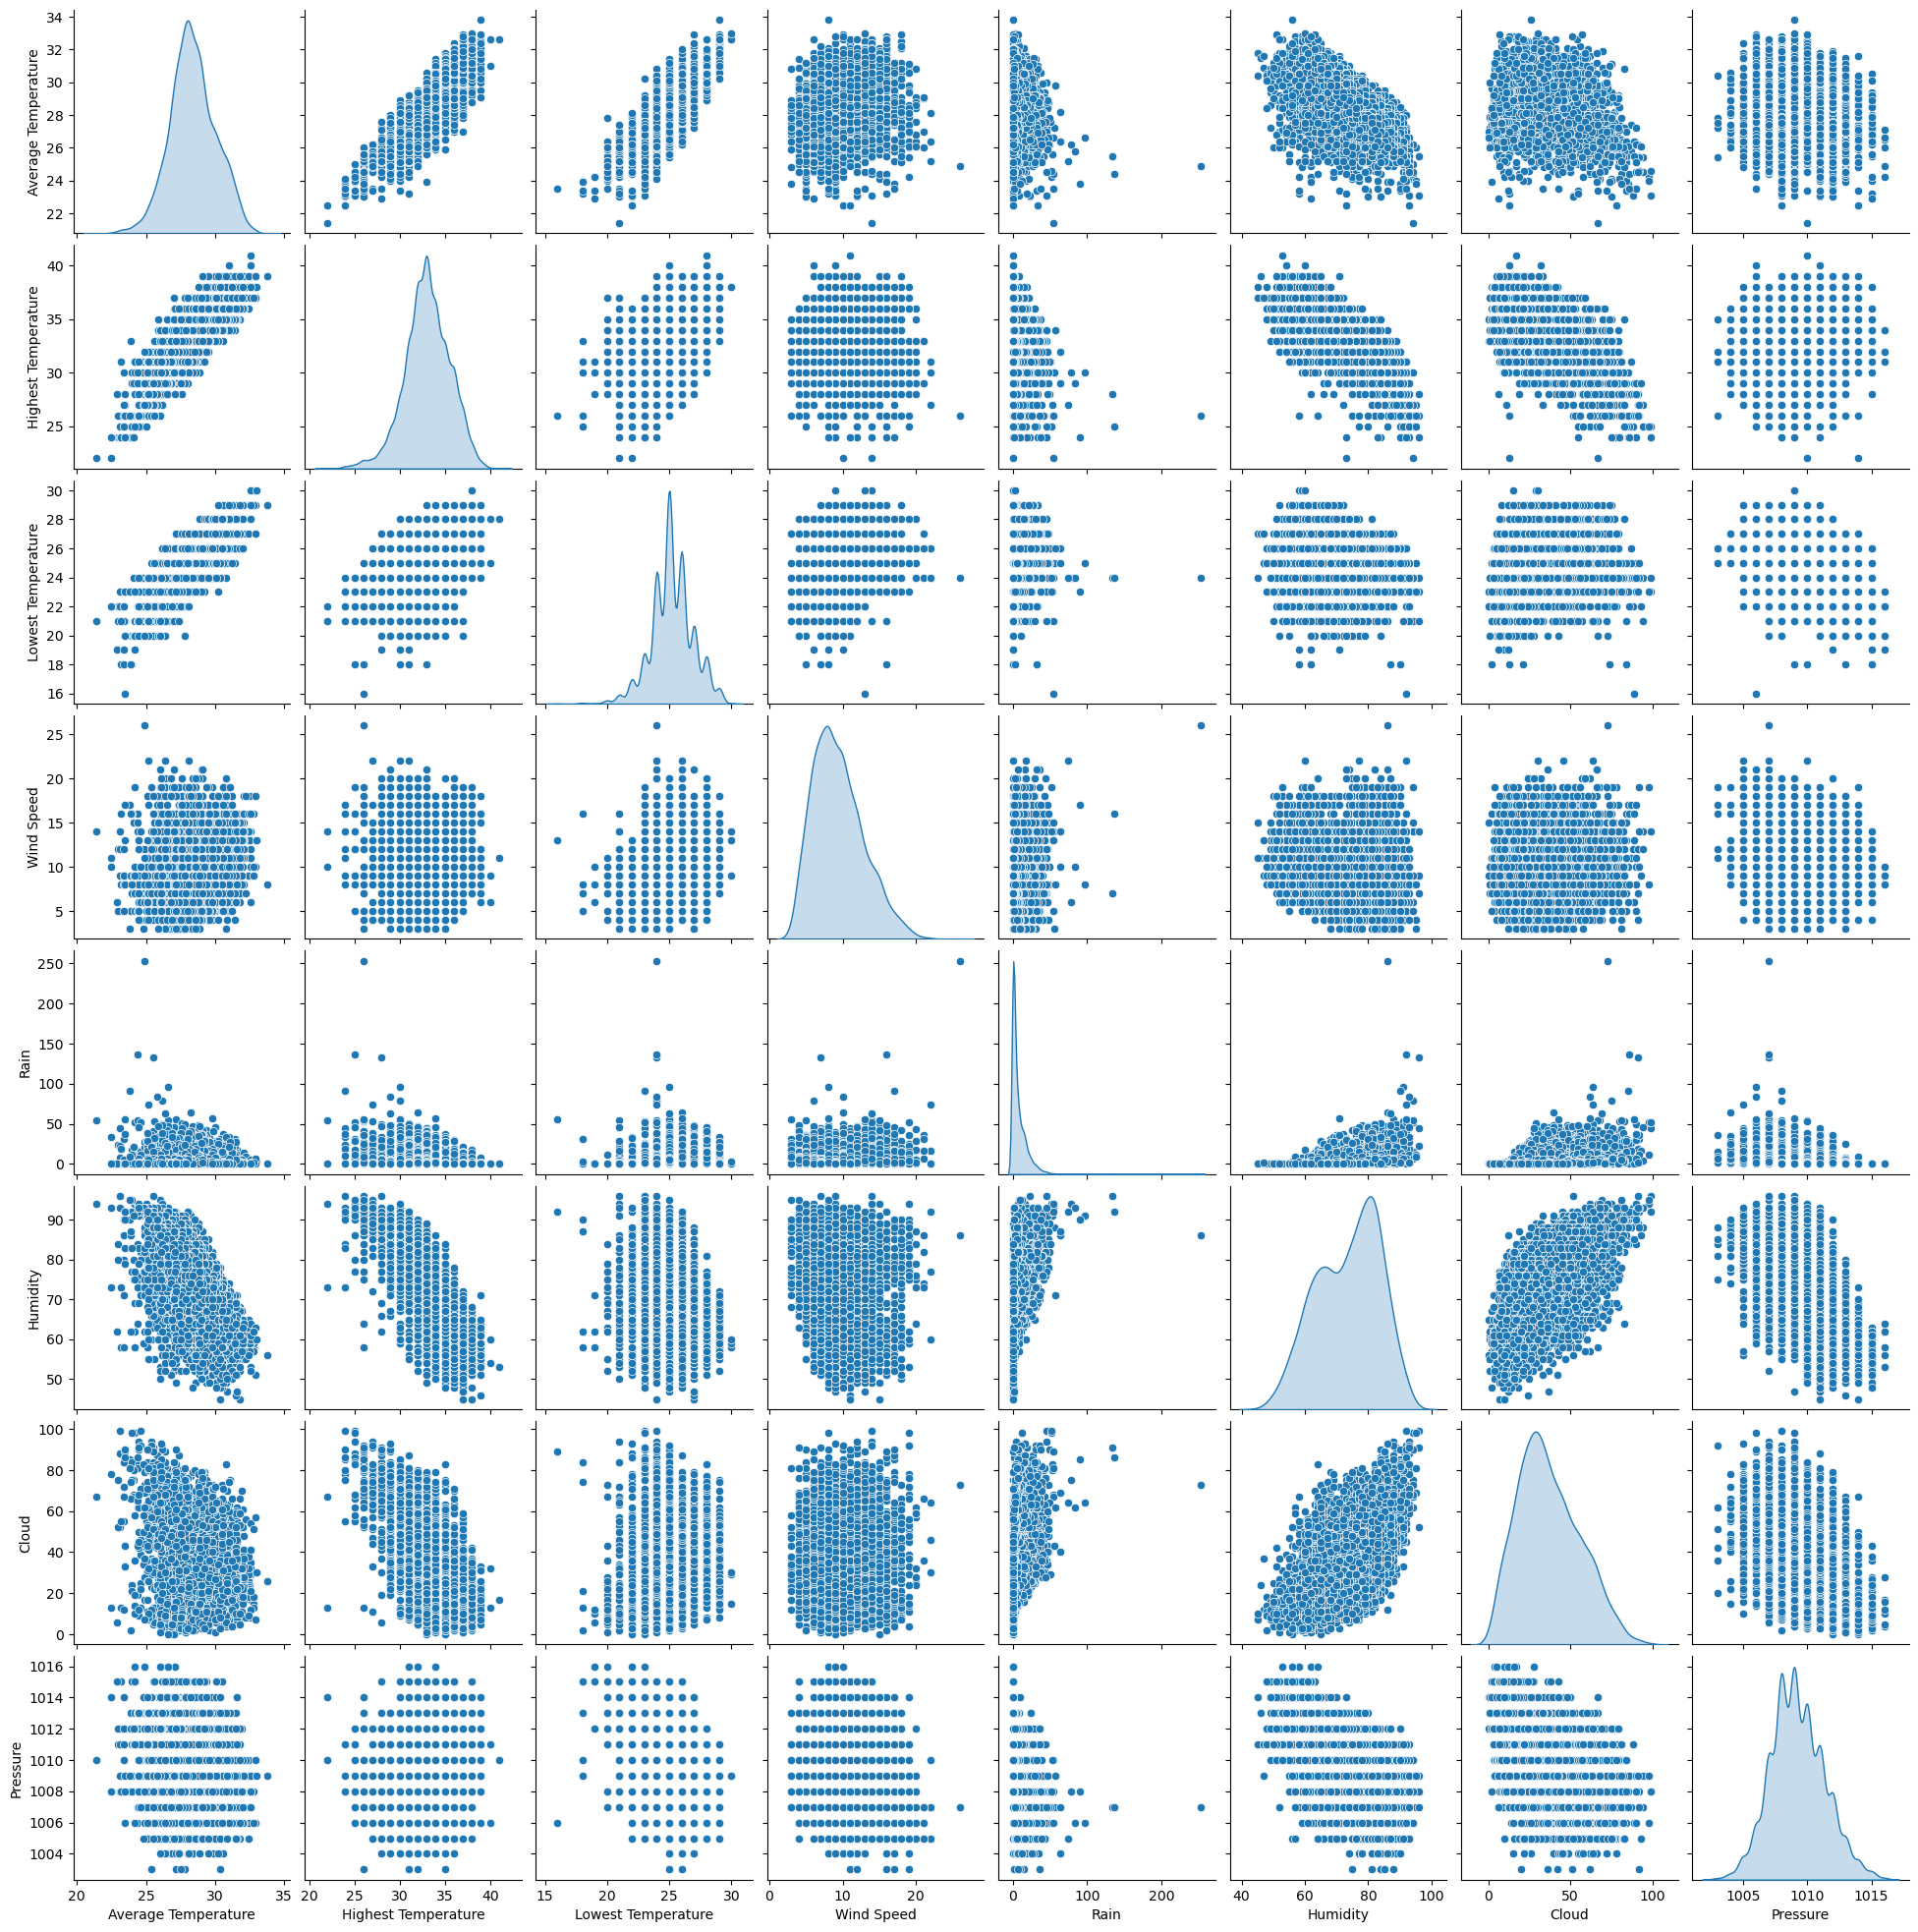

In [28]:
pair_plot_num = sns.pairplot(weather_df, diag_kind="kde");

**Từ pairplot trên, ta thấy có 1 vài thuộc tính có dữ liệu là phân phối lệch**

In [29]:
weather_df[num_attributes].skew().sort_values(ascending=False)

Rain                   4.893424
Wind Speed             0.626860
Cloud                  0.443901
Pressure               0.235952
Average Temperature   -0.014926
Lowest Temperature    -0.239299
Humidity              -0.285281
Highest Temperature   -0.321746
dtype: float64

- **"Rain" có phân phối lệch phải rất lớn**
- **"Rain" và "Wind Speed" là 2 thuộc tính cần xử lí phân phối lệch**.

Vẽ heatmap về correlation giữa các thuộc tính

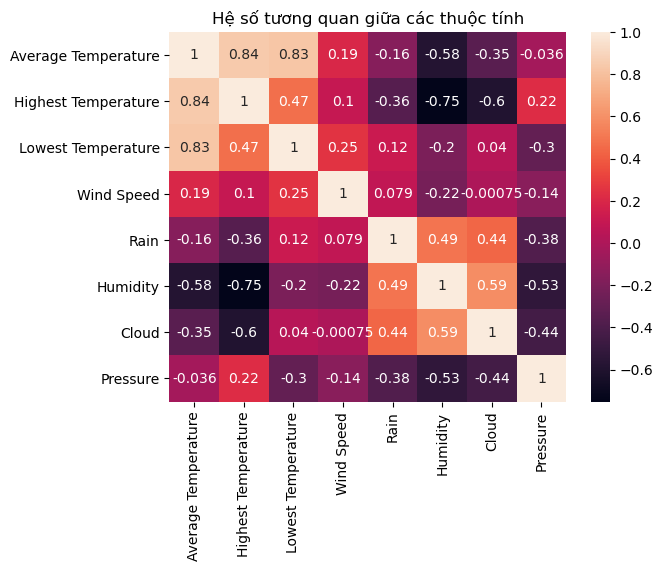

In [30]:
corr_matrix = weather_df.corr()
sns.heatmap(corr_matrix, annot =True).set(title="Hệ số tương quan giữa các thuộc tính");

**Từ heatmap trên, ta có thể thấy:**
- "Highest Temperature", "Lowest Temperature", "Humidity" là 3 thuộc tính có độ lớn của giá trị tương quan lớn nhất với "Average Temperature"
- "Pressure" có độ lớn của giá trị tương quan với "Average Temperature" rất nhỏ nhưng lại có độ lớn của giá trị tương quan với "Humidity" lớn

Vẽ biểu đồ thể hiển sự thay đổi giá trị của từng thuộc tính theo từng tháng qua từng năm

In [31]:
weather_df = weather_df.set_index('Date')

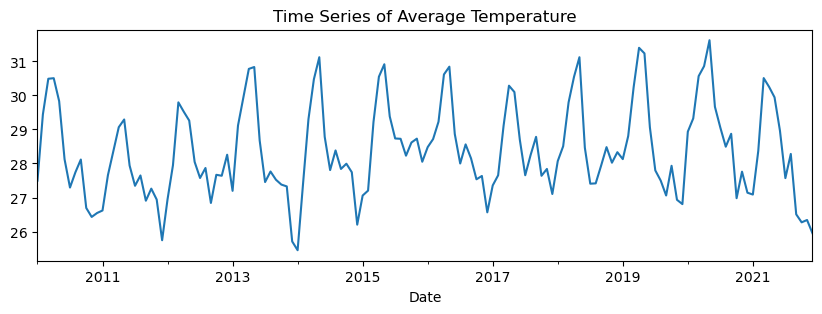

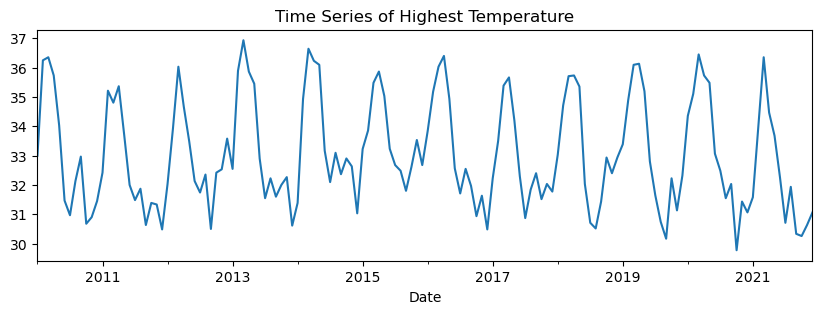

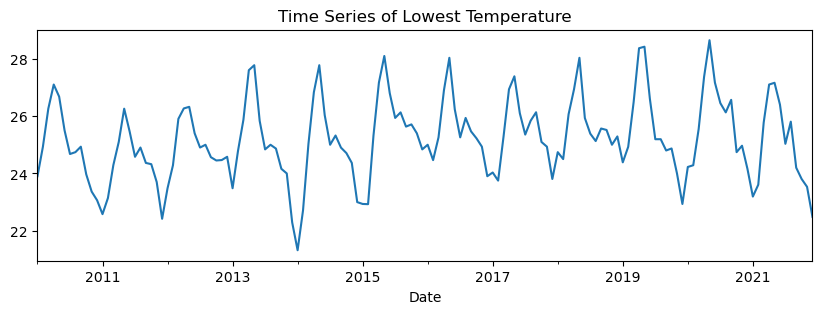

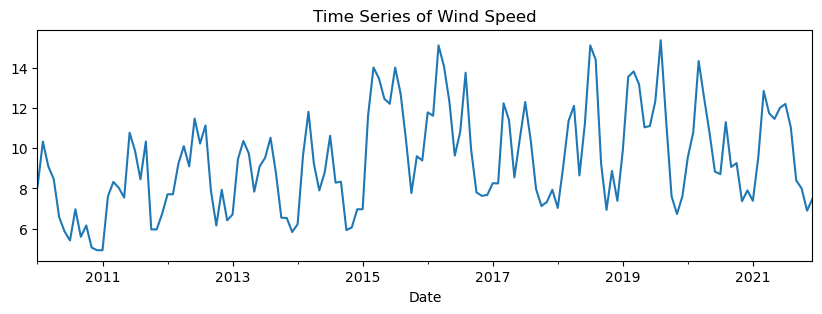

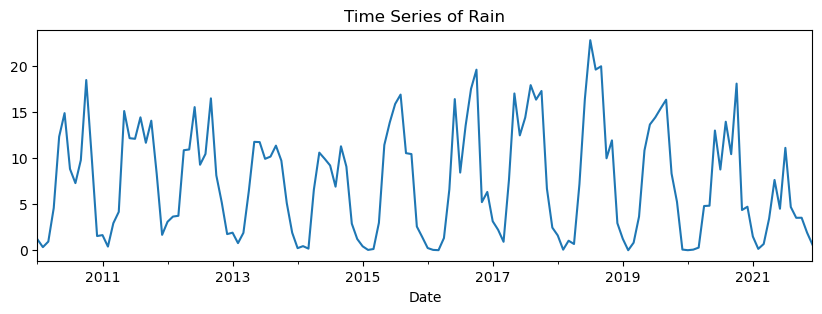

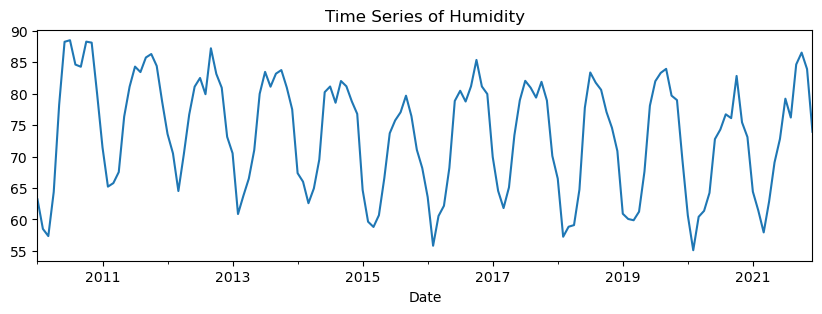

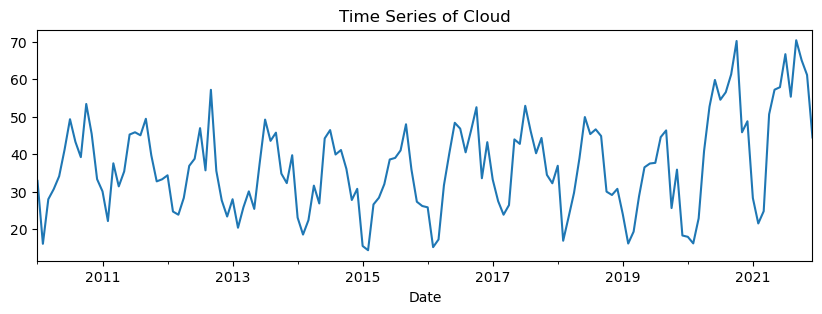

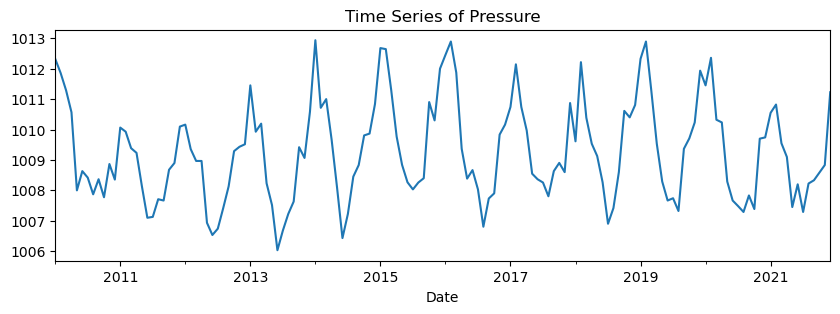

In [32]:
for att in num_attributes:
    #tính giá tri trung binh tung tháng
    df_timeseries = weather_df[att].resample('MS').mean()
    df_timeseries.plot(figsize=(10, 3))
    plt.title(f"Time Series of {att}")
    plt.show()

## B Chuẩn bị dữ liệu

### B.1 Tạo dataset cho training và testing của Time Series

Ta sẽ sử dụng N ngày trước đây để dự đoán nhiệt độ ngày hôm nay.
Hàm **extract_n_past_days** dùng để tạo ra dataframe đấy.

In [33]:
def extract_n_past_days(df, n, attributes):
    new_df= df.copy()
    rows = new_df.shape[0]
    for i in range(n):
        for attribute in attributes:
            col_values_i = new_df[attribute].shift(i+1)
            col_name = "{}_{}".format(attribute, i+1)
            new_df[col_name] = col_values_i
    return new_df

Ở đây, ta sẽ dùng N=3

In [34]:
data_extracted = extract_n_past_days(weather_df, 3, cat_attributes+num_attributes)

In [35]:
data_extracted.dropna(inplace=True)

In [36]:
X = data_extracted.drop(['Weather Type', 'Average Temperature', 'Highest Temperature',
       'Lowest Temperature', 'Wind Speed', 'Rain', 'Humidity', 'Cloud', 'Pressure'], axis = 1)
y = data_extracted['Average Temperature'].copy()

Dữ liệu thời tiết từ 2010-2021 gồm 12 năm. Ta chia bộ dữ liệu thành 10 năm đầu cho training và 2 năm cuối cho testing.

In [37]:
X_train = X[X.index.year<2020]
y_train = y[y.index.year<2020]

X_test = X[X.index.year>=2020]
y_test = y[y.index.year>=2020]

### B.2 Xử lí cột có kiểu dữ liệu phân loại, xử lí phân phối lệch và chuẩn hóa dữ liệu.

#### Bây giờ ta sẽ xử lí các vấn đề được nêu ở trên của bộ dữ liệu, bao gồm:
- Chuẩn hóa dữ liệu: dùng StandardScaler của thư viện sklearn.
- Xử lí cột có kiểu dữ liệu phân loại thành dạng one hot: dùng OneHotEncoder của thư viện sklearn.
- Xử lí phân phối lệch: Viết custom class HandleSkewedDistribution để xử lí.
- Ta sẽ dùng Pipeline và ColumnTransformer của sklearn để tạo pipeline xử lí cả 3 vấn đề trên.

In [38]:
cat_attris = ['Weather Type_1', 'Weather Type_2', 'Weather Type_3']

In [39]:
num_attributes_selected = X_train.columns.values
num_attributes_selected = num_attributes_selected[~np.isin(num_attributes_selected, cat_attris)]

In [40]:
class HandleSkewedDistribution(BaseEstimator, TransformerMixin):
    def __init__(self, skew_thres = 0.5, mask=[]):
        self.skew_thres = skew_thres
        self.mask=mask
    def fit(self, X, y=None):
        tmp=np.array(X)
        self.mask = np.abs(skew(tmp)) > self.skew_thres
        return self 
    def transform(self, X, y=None):
        X = np.array(X)
        skewed = np.log1p(X[:, self.mask])
        X[:, self.mask] = skewed
        return X

In [41]:
#numeric pipeline
num_pipeline = Pipeline([
    ('handle_skew', HandleSkewedDistribution()),
    ('std_scaler', StandardScaler()),
])

In [42]:
#apply transform for entire dataframe
full_pipeline = ColumnTransformer([
                                    ("num", num_pipeline, num_attributes_selected),
                                    ("cat", OneHotEncoder(), cat_attris),
])

## C Mô hình hóa dữ liệu

**Bây giờ sẽ đến phần mô hình hóa dữ liệu, ta sẽ thử nghiệm với các mô hình học máy.**

### Machine Learning

In [43]:
#transform train data
X_train_prepared = full_pipeline.fit_transform(X_train)
#transform test data
X_test_prepared = full_pipeline.transform(X_test)

Ta thử nghiệm với mô hình học máy đơn giản là Linear Regression.

#### Linear Regression

In [44]:
#create model
lr = linear_model.LinearRegression()

In [45]:
lr.fit(X_train_prepared, y_train)
predict = lr.predict(X_test_prepared)

In [46]:
#r2 score for train
print(f"r2 score of train dataset: {lr.score(X_train_prepared, y_train)}")

r2 score of train dataset: 0.8219882562092536


In [47]:
#r2 score for test
print(f"r2 score of train dataset: {lr.score(X_test_prepared, y_test)}")

r2 score of train dataset: 0.7387219459630585


In [48]:
#mean squared error score of test dataset
print(f"mean squared error score of test dataset: {mean_squared_error(predict, y_test)}")

mean squared error score of test dataset: 1.0176752699205318


In [49]:
#root mean squared error score of test dataset
print(f"root mean squared error score of test dataset: {np.sqrt(mean_squared_error(predict, y_test))}")

root mean squared error score of test dataset: 1.0087989244247497


Ta thử sử dụng mô hình phức tạp hơn là SVR. Các hyperparameters được chọn theo kinh nghiệm. Trong phần evaluation ta sẽ tìm cách chọn các hyperparameters tốt nhất.

#### Support Vectors Machine

In [50]:
svr = SVR(kernel='rbf', C=1e2, gamma=0.0001)
svr.fit(X_train_prepared, y_train)
svr_pred = svr.predict(X_test_prepared)

In [51]:
#r2 score for train
print(f"r2 score of train dataset: {svr.score(X_train_prepared, y_train)}")

r2 score of train dataset: 0.8156709542155092


In [52]:
#r2 score for test
print(f"r2 score of test dataset: {svr.score(X_test_prepared, y_test)}")

r2 score of test dataset: 0.7412580544195118


In [53]:
#mean squared error score of test dataset
print(f"mean squared error score of test dataset: {mean_squared_error(svr_pred, y_test)}")

mean squared error score of test dataset: 1.0077971541810296


In [54]:
#root mean squared error score of test dataset
print(f"root mean squared error score of test dataset: {np.sqrt(mean_squared_error(svr_pred, y_test))}")

root mean squared error score of test dataset: 1.003891007122302


Ta thử với 1 mô hình khác là XGBoostRegressor. Các hyperparameters được chọn theo kinh nghiệm. Trong phần evaluation ta sẽ tìm cách chọn các hyperparameters tốt nhất.

#### XGBoostRegressor

In [55]:
xgb_regressor = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_regressor.fit(X_train_prepared, y_train)
xgb_regressor_pred = xgb_regressor.predict(X_test_prepared)

In [56]:
#r2 score for train
print(f"r2 score of train dataset: {xgb_regressor.score(X_train_prepared, y_train)}")

r2 score of train dataset: 0.9999989387347549


In [57]:
#r2 score for test
print(f"r2 score of test dataset: {xgb_regressor.score(X_test_prepared, y_test)}")

r2 score of test dataset: 0.727101383829855


Mô hình XGBoostRegressor có vẻ là bị overfitting.

In [58]:
#mean squared error score of test dataset
print(f"mean squared error score of test dataset: {mean_squared_error(y_test, xgb_regressor_pred)}")

mean squared error score of test dataset: 1.0629372370961758


In [59]:
#root mean squared error score of test dataset
print(f"root mean squared error score of test dataset: {np.sqrt(mean_squared_error(y_test, xgb_regressor_pred))}")

root mean squared error score of test dataset: 1.0309884757339316


## D Đánh giá mô hình

### Machine Learning

#### SVR với kernel là rbf, sigmoid. Dùng GridSearchCV để tìm C và gamma tốt nhất.

In [60]:
params_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
              'kernel': ['rbf', 'sigmoid']}  
  
grid = GridSearchCV(SVR(), params_grid, refit = True, verbose = 3, cv=3)

grid.fit(X_train_prepared, y_train) 

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.030 total time=   0.7s
[CV 2/3] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.047 total time=   0.6s
[CV 3/3] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.015 total time=   0.6s
[CV 1/3] END .C=0.1, gamma=1, kernel=sigmoid;, score=-400.733 total time=   0.6s
[CV 2/3] END .C=0.1, gamma=1, kernel=sigmoid;, score=-311.117 total time=   0.6s
[CV 3/3] END .C=0.1, gamma=1, kernel=sigmoid;, score=-390.928 total time=   0.6s
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.591 total time=   0.5s
[CV 2/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.638 total time=   0.5s
[CV 3/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.639 total time=   0.5s
[CV 1/3] END C=0.1, gamma=0.1, kernel=sigmoid;, score=-70.161 total time=   0.5s
[CV 2/3] END C=0.1, gamma=0.1, kernel=sigmoid;, score=-55.310 total time=   0.5s
[CV 3/3] END C=0.1, gamma=0.1, kernel=sigmoid;,

[CV 3/3] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.761 total time=   0.3s
[CV 1/3] END .....C=10, gamma=1e-05, kernel=rbf;, score=0.699 total time=   0.5s
[CV 2/3] END .....C=10, gamma=1e-05, kernel=rbf;, score=0.731 total time=   0.4s
[CV 3/3] END .....C=10, gamma=1e-05, kernel=rbf;, score=0.698 total time=   0.5s
[CV 1/3] END .C=10, gamma=1e-05, kernel=sigmoid;, score=0.614 total time=   0.3s
[CV 2/3] END .C=10, gamma=1e-05, kernel=sigmoid;, score=0.622 total time=   0.3s
[CV 3/3] END .C=10, gamma=1e-05, kernel=sigmoid;, score=0.616 total time=   0.3s
[CV 1/3] END .......C=100, gamma=1, kernel=rbf;, score=-0.047 total time=   0.9s
[CV 2/3] END .......C=100, gamma=1, kernel=rbf;, score=-0.004 total time=   0.8s
[CV 3/3] END ........C=100, gamma=1, kernel=rbf;, score=0.005 total time=   0.8s
[CV 1/3] END C=100, gamma=1, kernel=sigmoid;, score=-439938509.515 total time=   0.5s
[CV 2/3] END C=100, gamma=1, kernel=sigmoid;, score=-385781937.247 total time=   0.5s
[CV 3/3] END C=100

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=3)

In [61]:
# print best hyperparameter after tuning 
print(grid.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


Đây là bộ hyperparameters tốt nhất tìm được sau khi dùng GridSearchCV

In [62]:
#predict cua mo hinh SVR tot nhat sau fine tuning
grid_svr_predict = grid.predict(X_test_prepared)

In [63]:
#r2 score for train
print(f"r2 score of train dataset: {grid.score(X_train_prepared, y_train)}")

r2 score of train dataset: 0.8347338397649571


In [64]:
#r2 score for test
print(f"r2 score of test dataset: {grid.score(X_test_prepared, y_test)}")

r2 score of test dataset: 0.7484465562391733


In [65]:
#mean squared error score of test dataset
print(f"mean squared error score of test dataset: {mean_squared_error(y_test, grid_svr_predict)}")

mean squared error score of test dataset: 0.9797980152689876


In [66]:
#root mean squared error score of test dataset
print(f"root mean squared error score of test dataset: {np.sqrt(mean_squared_error(y_test, grid_svr_predict))}")

root mean squared error score of test dataset: 0.9898474707089914


#### XGBoostRegressor với RandomizedSearchCV để tìm các hyperparameters tốt nhất.

In [67]:
params = {
     "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "eta": [0.001, 0.01, 0.1],
     "subsample": [0.4, 0.6, 0.7, 0.8]
}

In [68]:
random_searchcv=RandomizedSearchCV(xgb.XGBRegressor(),param_distributions=params,n_iter=10,cv=3,verbose=3)

In [69]:
random_searchcv.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.7, eta=0.01, gamma=0.4, max_depth=5, subsample=0.8;, score=-43.587 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eta=0.01, gamma=0.4, max_depth=5, subsample=0.8;, score=-38.744 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eta=0.01, gamma=0.4, max_depth=5, subsample=0.8;, score=-42.510 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, eta=0.01, gamma=0.0, max_depth=3, subsample=0.6;, score=-43.586 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, eta=0.01, gamma=0.0, max_depth=3, subsample=0.6;, score=-38.803 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, eta=0.01, gamma=0.0, max_depth=3, subsample=0.6;, score=-42.567 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, eta=0.1, gamma=0.4, max_depth=5, subsample=0.8;, score=0.768 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, eta=0.1, gamma=0.4, max_depth=5, subsample=0.8;, score=0.819 total time=   0.0s
[

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_al

In [70]:
# print best hyperparameter after tuning 
print(random_searchcv.best_params_)

{'subsample': 0.8, 'max_depth': 5, 'gamma': 0.4, 'eta': 0.1, 'colsample_bytree': 0.5}


In [71]:
#predict cua mo hinh xgboostregressor tot nhat sau fine tuning
random_searchcv_predict = random_searchcv.predict(X_test_prepared)

In [72]:
#r2 score for train
print(f"r2 score of train dataset: {random_searchcv.score(X_train_prepared, y_train)}")

r2 score of train dataset: 0.8956467834617865


In [73]:
#r2 score for test
print(f"r2 score of test dataset: {r2_score(y_test ,random_searchcv_predict)}")

r2 score of test dataset: 0.752929675522932


In [74]:
#mean squared error score of test dataset
print(f"mean squared error score of test dataset: {mean_squared_error(y_test, random_searchcv_predict)}")

mean squared error score of test dataset: 0.9623363128539046


In [75]:
#root mean squared error score of test dataset
print(f"root mean squared error score of test dataset: {np.sqrt(mean_squared_error(y_test, random_searchcv_predict))}")

root mean squared error score of test dataset: 0.9809874172760346


**Nhận xét:**
- Nhìn chung các 3 mô hình ở trên đều cho ra các kết quả xấp xỉ nhau dựa trên các độ đo như r2 score, mse, rmse.
- Nếu được deploy thì mô hình Linear Regression sẽ được chọn vì mô hình vửa đơn giản và vừa có kết quả tốt như mô hình phức tạp khác.

# Reference

1. https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73
2. https://scikit-learn.org/stable/
3. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition
4. https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45